# ResNet18 Test - from torchvison models

This code is a test of an adversarial attack on the ResNet18 architecture as proposed by: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf). This notebook focuses only on the CIFAR100 dataset of coloured pictures.

Apperently `torchvision` already had the model **ResNet18** under models... So this is an attempt with that model instead of all that GitHub code.. god damnit.


## Basic Imports

In [6]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, utils, models
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import exists
%matplotlib inline


# Path for where we save the model
# this is a magic tool that will come in handy later ;)
saveModelPath = "../trainedModels/adversarial_VGG19_cifar100.pth"

## Important if you want to train again, set this to True
tryResumeTrain = True

## WARNING!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# This boolean will completely wipe any past checkpoints or progress.
# ASSIGN IT WITH CARE.
completelyRestartTrain = True

# Inarguably a weird place to initialize the number of epochs
# but it is a magic tool that will come in handy later.
numEpochs = 25

## Dumb function
...that I will probably only use a couple of times.

In [7]:
def msg(
    message: str,
):
    """
    Input:
        message (str): a message of type string, which will be printed to the terminal
            with some decoration.

    Description:
        This function takes a message and prints it nicely

    Output:
        This function has no output, it prints directly to the terminal
    """

    # word_list makes sure that the output of msg is more readable
    sentence_list = message.split(sep="\n")
    # the max-function can apparently be utilised like this:
    longest_sentence = max(sentence_list, key=len)

    n = len(longest_sentence)
    n2 = n // 2 - 1
    print(">" * n2 + "  " + "<" * n2)
    print(message)
    print(">" * n2 + "  " + "<" * n2 + "\n")

## Basic configuration and epsilons
We need some epsilons indicating how much noise is added. This is kept as a list. For different sizes of attack. How great the attack. Then we also need to specify whether we use the GPU (Cuda) or not. With my potato the CPU is the only choice.

In [8]:
epsilons = torch.linspace(0, 0.3, 6)

# one, because zero-index is zero, so distance between them is just value of one-index
eps_step_size = epsilons[1].item()  

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Downloading data

Downloading those pesky numbies.

In [9]:
batch_size = 128

train_data = datasets.CIFAR100(
    root = '../data/datasetCIFAR100',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

trainloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1
    )

test_data = datasets.CIFAR100(
    root = '../data/datasetCIFAR100', 
    train = False, 
    transform = ToTensor()
)

testloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1
    )

classes = train_data.classes # or class_to_idx

Files already downloaded and verified


## Show some images

Because we have done it so much now. It has just become tradition. We need to see some of dem images!

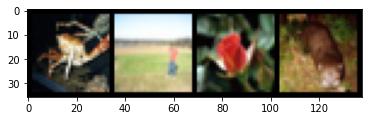

crab  plain rose  otter


In [10]:
# get some random training images
# The "iter( )" function makes an object iterable.
# Meaning that we still can't subscribt it, however we can call the next 
# "instance" (I guess is an apt name), over and over. 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
gridedImages = utils.make_grid(images[:4])
npimg = gridedImages.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

### Intermediary test
Testing whether the pics are in range [0,1]

In [11]:
I_Want_Intermediary_Test = True
Nsamples = 10

if I_Want_Intermediary_Test:
    # Finding max of input images
    from math import inf
    maxNum = -inf
    minNum = inf
    for i in range(Nsamples):
        sample_idx = torch.randint(len(train_data), size=(1,)).item()
        img, _ = train_data[sample_idx]
        tempMax = torch.max(img)
        tempMin = torch.min(img)
        if maxNum < tempMax:
            maxNum = tempMax
        if tempMin < minNum:
            minNum = tempMin

    msg(f"Smallest in number in these images: {minNum}\n Greatest number in sample images: {maxNum}")
    

>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<
Smallest in number in these images: 0.0
 Greatest number in sample images: 1.0
>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<



## Downloading the VGG19 model

Getting the model from the stolen GitHub code.

In [12]:
# Returns the vgg19 model
model = models.vgg19(pretrained=False).to(device)


## Defining loss and optimization function

Both the loss function and the optimization function needs to be defined for this particular neural network.
They are defined as follows.

(Why it is always that CrossEntropyLoss.. I do not know)

In [13]:
lrn_rt = 1e-3

loss_fn = nn.CrossEntropyLoss()

# We are just going to use Adam, because it has proven to be effective.
optimizer = optim.Adam(model.parameters(), lr=lrn_rt)

## Checkpoint shenaniganz
It is quite useful to have checkpoints when training humongous models, that is what this code handles.

In [14]:
# It is important that it is initialized to zero
# if we are in the case that a model hasn't been trained yet.
accuracies = np.zeros((2, numEpochs))
losses = np.zeros((2, numEpochs))
            
# exists is a function from os.path (standard library)
trained_model_exists = exists(saveModelPath)

if trained_model_exists:
    if completelyRestartTrain:
        os.remove(saveModelPath)
        startEpoch = 0
        msg("Previous model was deleted. \nRestarting training.")
    else:
        import collections
        if not (type(torch.load(saveModelPath)) is collections.OrderedDict):
            ## If it looks stupid but works it ain't stupid B)
            #
            # I think if it isn't that datatype, then it saved the Alex-way
            # and then we can load stuff.
            # Because if it is that datatype then it is for sure "just" the state_dict.
            
            checkpoint = torch.load(saveModelPath)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            num_previous_epochs = checkpoint['accuracies'].shape[1]
            
            if num_previous_epochs < numEpochs:
                # if we trained to fewer epochs previously,
                # now we train to the proper amount, therfore padded zeroes are required.
                remainingZeros = np.zeros((2,numEpochs-num_previous_epochs))
                checkpoint['accuracies'] = np.concatenate((checkpoint['accuracies'], remainingZeros), axis=1)
                checkpoint['losses'] = np.concatenate((checkpoint['losses'], remainingZeros), axis=1)
                
            if numEpochs < num_previous_epochs:
                # Just cut off our data at the required amount of epochs, so nothing looks funky.
                checkpoint['accuracies'] = checkpoint['accuracies'][:,:numEpochs]
                checkpoint['losses'] = checkpoint['losses'][:,:numEpochs]
            
            # we save at the epoch we completed, but we wan't to start at the following epoch
            startEpoch = checkpoint['epoch'] + 1 
            
            if startEpoch < numEpochs:
                # we add one to startEpoch here (in the message) to make up for
                # the for-loop being zero-indexed.
                msg(f"Model will resume training from epoch: {startEpoch + 1}")
                
                # grapping our accuracies from the previously trained model
                accuracies = checkpoint['accuracies']
                losses = checkpoint['losses']
                
            elif tryResumeTrain and startEpoch >= numEpochs:
                msg("Model has already finished training. "
                    + "\nDo you wan't to delete previous model and start over?")
                userInput = input("Input [y/n]:\t")
                while userInput.lower() != 'y' and userInput.lower != 'n':
                    userInput = input("You must input either 'y' (yes) or 'n' (no):\t")
                if userInput.lower() == "y":
                    os.remove(saveModelPath)
                    startEpoch = 0
                    msg("Previous model was deleted. \nRestarting training!")
                elif userInput.lower() == "n":
                    msg("Model had already finished training and no new training will commence.")
                    
            elif not tryResumeTrain and startEpoch >= numEpochs:
                msg(f"Model finished training at epoch: {startEpoch}")
                # grapping our accuracies from the previously trained model
                accuracies = checkpoint['accuracies']
                losses = checkpoint['losses']
                            
else:
    #Trained model doesn't exist
    msg("There was no previously existing model. \nTraining will commence from beginning.")
    startEpoch = 0
    
            


>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<
There was no previously existing model. 
Training will commence from beginning.
>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<



## The Training and Testing Loop

The loops for training and testing:

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for batch, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Compute prediction and loss
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        current_batch_size = len(inputs)
        
        if batch % (10000//current_batch_size):
            loss, current = loss.item(), batch * current_batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches        
    correct /= size
    return 100*correct, train_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            pred = model(inputs)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

## Training the network

Obviously we also need to fit some weights, so here is the code for training the network.

In [33]:
# We train if we haven't already trained
# or we want to train again.
if not trained_model_exists or tryResumeTrain or startEpoch < (numEpochs - 1):

    for t in range(startEpoch, numEpochs):
        print(f"Epoch {t+1}\n-------------------------------")
        accuracyTrain, avglossTrain = train_loop(trainloader, model, loss_fn, optimizer)
        accuracyTest, avglossTest = test_loop(testloader, model, loss_fn)
        
        # This is just extra for plotting
        accuracies[0,t], accuracies[1,t] = accuracyTest, accuracyTrain
        losses[0,t], losses[1,t] = avglossTest, avglossTrain
        
        # Checkpoint
        torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracies': accuracies,
            'losses': losses
            }, saveModelPath)
        print(f"Checkpoint at epoch: {t + 1}")
        
    msg(f"Done! Final model was saved to: \n'{saveModelPath}'")
    
else:
    msg("Have already trained this model once!")



Epoch 1
-------------------------------
Is this the number of batches: 1563
Is this the batch_size? 32
loss: 6.908528  [    0/50000]
Is this the batch_size? 32
loss: 6.563495  [   32/50000]
Is this the batch_size? 32
loss: 150.234634  [   64/50000]


KeyboardInterrupt: 

### Optional code for plotting
If you wanna see the development of the accuracy and the avg loss, this is the plot for you!

In [ ]:
# ABP - Always Be Plotting (or Pushing if you are into git)

xVals = list(range(1, numEpochs + 1))

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle(f"Accuracy and loss over {numEpochs} epochs")

ax1.plot(xVals, accuracies[0], 'o-', label="Test")
ax1.plot(xVals, accuracies[1], 'o-', label="Train")
ax1.legend()
ax1.set_ylabel("Accuracy over epochs")

ax2.plot(xVals, losses[0], '.-', label="Test")
ax2.plot(xVals, losses[1], '.-', label="Train")
ax2.legend()
ax2.set_xlabel("epochs")
ax2.set_ylabel("AVG loss over epochs")

plt.show()

## Saving and loading model
There is no longer need to save the model as it is saved during checkpoints.

(Actually, saving the model this way is destructive as the code have been rewritten to expect a dictionary of more values.)

### Load
Loading the model afterwards... quite an important part of the process.

In [ ]:
model = models.vgg19(pretrained=False).to(device)
checkpoint = torch.load(saveModelPath)
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

## FGSM Attack
(Fast Gradient Sign Method) Attack.
Here we define the function that creates the adversarial example by disturbing the original image.

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing function
This is a testing function written by the peeps at pyTorch. It seems like it does a lot, I am not entirely sure what everything is though.

In [ ]:
def test(model, device, test_loader, epsilon, someSeed):
    # Manxi's superior testing function

    # Accuracy counter
    # correct = 0
    adv_examples = []
    adv_imgs = []
    adv_pred_labels = []
    adv_attack_labels = []
    pred = []
    gt = []
    
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        _, init_pred_index = output.max(1, keepdim=True) # get the index of the max log-probability
    
        idx = (init_pred_index.flatten() == target.flatten()) # B, bool 
        
        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data
        
        # NOTE: I put the indexing after the back propagation, 
        # so that "data" appears on the computation graph 
        # (which is used for computing the gradient)
        
        data_grad = data_grad[idx, ...]
        if not data_grad.size(0):
            continue        
        
        data = data[idx, ...]
        output = output[idx, ...] # N, C
        target = target[idx] # N
        init_pred_index = init_pred_index[idx, ...]

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        # print(f"second output: {output}")

        # Check for success
        final_pred = output.max(1, keepdim=True) # get the index of the max log-probability
        
        final_pred_index = final_pred[1]
        
        adv_ex = perturbed_data.detach()
        adv_imgs.append(adv_ex)
        adv_pred_labels.append(init_pred_index.detach())
        adv_attack_labels.append(final_pred_index.detach())

        pred.append(final_pred_index.flatten().detach().cpu().numpy())
        gt.append(init_pred_index.flatten().detach().cpu().numpy())
        
    # Calculate final accuracy for this epsilon
    #final_acc = correct/float(len(test_loader)) # This is for computing the accuracy over batches
    # We usually compute the accuracy over instances
    pred = np.concatenate(pred, axis=0)
    gt = np.concatenate(gt, axis=0)
    correct = np.sum(pred == gt)
    final_acc = correct / len(gt)
    
    # np.random.seed(0) # if you would like to make the result repeatable, you should fix the random seed    
    np.random.seed(someSeed)
    adv_imgs = torch.cat(adv_imgs, dim=0).cpu().numpy()
    num_random_imgs = 5
    
    img_num = adv_imgs.shape[0]
    rndm_imgs_ID = np.arange(img_num)
    np.random.shuffle(rndm_imgs_ID)
    rndm_imgs_ID = rndm_imgs_ID[:num_random_imgs] # now we randomly pick 5 indices
        
    adv_imgs = adv_imgs[rndm_imgs_ID, ...]
    adv_pred_labels = torch.cat(adv_pred_labels, dim=0).cpu().numpy()[rndm_imgs_ID, ...]
    adv_attack_labels = torch.cat(adv_attack_labels, dim=0).cpu().numpy()[rndm_imgs_ID, ...]
    
    adv_examples = [(adv_pred_labels[i, ...][0], adv_attack_labels[i, ...][0], adv_imgs[i, ...]) for i in range(num_random_imgs)]     
    
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(round(epsilon.item(), 3), correct, len(gt), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Finally we run the attack
This also saves some values, so that we can see how the accuracy falls along with greater epsilon (error) rates.


In [ ]:
accuracies = []
examples = []
someSeed = np.random.randint(low=0, high=2**30)        
        
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps, someSeed)
    accuracies.append(acc)
    examples.append(ex)

## Results
We make an **accuracy** vs. **epsilon*** plot and see that there is a clear correlation.

### Accuracy vs. Epsilon

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, torch.max(epsilons)+eps_step_size, step=eps_step_size))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversarial Examples
Here we show some of the images that are the results of adversarial attacks, alongside the prediction by the network :) 

In [ ]:
# Plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(round(epsilons[i].item(), 3)), fontsize=14)
        orig,adv,ex = examples[i][j]
        
        # CIFAR is complicated so we need to reshape and normalize..
        reshaped_ex = np.transpose(ex, (1, 2, 0))
        #print(f"min: {min(reshaped_ex.flatten())}")
        #normalised_ex = reshaped_ex / 2     # unnormalize
        #print(f"max: {max(reshaped_ex.flatten())}")
        
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        plt.imshow(reshaped_ex)
plt.tight_layout()
plt.show()